In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering


# Demo - Embedding Initialisation

This demo is an extension on `1_default_usage.ipynb` and shows how you can initialise the model using pre-trained sentence embeddings. For this demo, we'll make use of Google's [universal-sentence-encoding-multilingual](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3) model.

The main idea behind initialising with pre-trained vectors is that the sentences similar to the labeled sentences (i.e. those in the training and validation cluster) are initially closer to each other in the embedding space. This gives a greater chance that they adapt with them during training, hence leading to an overall better result for those samples not labeled.

The goal of this demo is to cluster Flemish universities to a suitable cluster, while discarding all other schools/universities.

In [3]:
import re
import json
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from collections import Counter
from matplotlib.ticker import MaxNLocator

from semi_supervised_clustering import EmbeddingModel

## Data

Load in the dummy-data used throughout this demonstration.

In [4]:
# Consider only the profiles scraped from LinkedIn
DATA_PATH = Path.cwd() / 'demos/demo_data.json'

# Name assigned to the clustering-model
name = 'demo_emb_init'

In [5]:
def clean_f(x:str) -> str:
    """Cleaning function of the raw text."""
    x = x.lower()
    return re.sub('\W+', ' ', x).strip()

In [6]:
# Load in the data, and clean
with open(DATA_PATH, 'r') as f:
    data = json.load(f)

In [7]:
data_clean = [clean_f(s) for s in data]
data_unique = sorted(set(data_clean))
print(f"Total of {len(data_clean)} data samples")
data_count = [(k, v) for k, v in sorted(Counter(data_clean).items(), key=lambda x: x[1])]
print(f" --> {len(data_count)} unique")

print(f"\n10 most frequent samples:")
for sample, count in list(reversed(data_count))[:10]:
    print(f" - {sample} ({count})")

Total of 4689 data samples
 --> 706 unique

10 most frequent samples:
 - ku leuven (518)
 - katholieke universiteit leuven (411)
 - universiteit gent (340)
 - hogeschool gent (298)
 - vrije universiteit brussel (155)
 - vlerick business school (127)
 - université catholique de louvain (126)
 - groep t internationale hogeschool leuven (117)
 - ghent university (104)
 - universiteit antwerpen (101)


Analyse on frequency:
 - Sample frequency >=  0  --> 100% of all samples (706 samples in total)
 - Sample frequency >= 50  -->  61% of all samples (18 samples in total)
 - Sample frequency >= 100 -->  49% of all samples (10 samples in total)
 - Sample frequency >= 150 -->  37% of all samples (5 samples in total)
 - Sample frequency >= 200 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 250 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 300 -->  27% of all samples (3 samples in total)
 - Sample frequency >= 350 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 400 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 450 -->  11% of all samples (1 samples in total)
 - Sample frequency >= 500 -->  11% of all samples (1 samples in total)


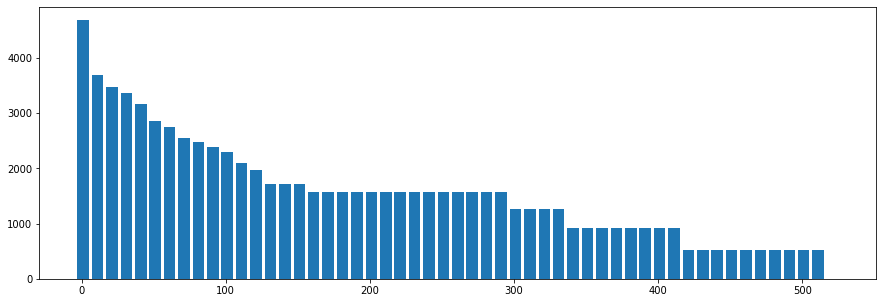

In [8]:
# Plot frequency of the data
counts = sorted([x for k,x in data_count], reverse=True)
x, y = [], []
for i in range(1, max(counts)+10, 10):
    x.append(i)
    y.append(sum(c for c in counts if i <= c))

print(f"Analyse on frequency:")
for freq in range(0,max(counts),50):
    print(f" - Sample frequency >= {freq:^3d} --> {round(100*sum(c for c in counts if freq <= c)/sum(counts)):3d}% of all samples ({len([c for c in counts if freq <= c])} samples in total)")

plt.figure(figsize=(15,5))
plt.bar(x, y, width=8)
plt.show()

## Model

Initialise the `EmbeddingModel`. This model consists of three main sub-models:
 - `encoder` to encode the raw sentences into machine-interpretable embeddings (multi-hot)
 - `embedder` to embed the multi-hot encoded vectors into dense embeddings
 - `clusterer` to cluster the dense embeddings and predict the best-suiting cluster

### Initialise

Initialise the model, by created each of its fundamental components. During this initialisation-step, you have the option to initialise the clusters yourselve (as done in this demo) or by answering a short survay of proposed clusters, done via CLI. The latter can be activated by setting `n_min_clusters` inside of `model.initialise_models` to a number larger than zero.

In [9]:
model = EmbeddingModel(
    name=name,
    path_model=Path.cwd() / f'demos/models/{name}',
    path_data=Path.cwd() / f'demos/data/{name}',
    clean_f=clean_f,
    vocab_size=200,
    model_layers=(50,50,),
    normalise=True,
    cluster_thr=.8,
)

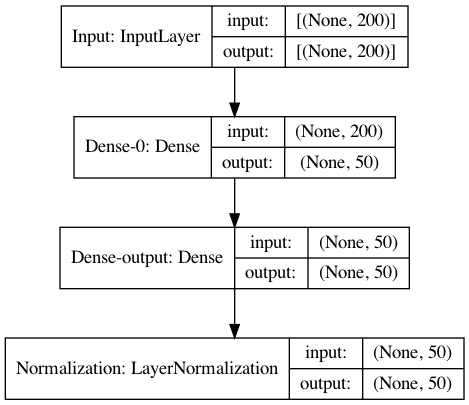

In [10]:
# Plot the model's architecture
tf.keras.utils.plot_model(
        model.embedder._model, Path.cwd() / f"demos/models/{name}/{model.embedder}.png",
        show_shapes=True,
)

In [11]:
# Create some initial clusters
model.initialise_models(
    data=data,
    reset=True,
    n_min_clusters=0,
    show_overview=True,
)



Analysing encoder 'encoder-demo_emb_init-bpe-200'

Analysing word 'ku leuven':
 --> Encoding: [38, 21]
 --> Word by word:
     - 38: ku
     - 21: leuven

Analysing word 'katholieke universiteit leuven':
 --> Encoding: [53, 29, 21]
 --> Word by word:
     - 53: katholieke
     - 29: universiteit
     - 21: leuven

Analysing word 'universiteit gent':
 --> Encoding: [29, 26]
 --> Word by word:
     - 29: universiteit
     - 26: gent

Analysing word 'hogeschool gent':
 --> Encoding: [32, 26]
 --> Word by word:
     - 32: hogeschool
     - 26: gent

Analysing word 'vrije universiteit brussel':
 --> Encoding: [102, 29, 57]
 --> Word by word:
     - 102: vrije
     - 29: universiteit
     - 57: brussel

Encoding the alphabet:
 - a = [36] = a
 - b = [42] = b
 - c = [64] = c
 - d = [177, 196] = d
 - e = [177, 176] = e
 - f = [174] = f
 - g = [12] = g
 - h = [78] = h
 - i = [141] = i
 - j = [177, 199] = j
 - k = [10] = k
 - l = [7] = l
 - m = [98] = m
 - n = [177, 178] = n
 - o = [81] = o
 - 

In [12]:
# Add training data manually
model.clusterer.add_clusters({
    'Catholic University of Leuven': ['kul', 'KU Leuven', 'katholieke universiteit leuven', 'Groep T', "Nayer Instituut", "universite de louvain"],
    'Free University of Brussels': ['VUB', 'Brussel Universiteit', 'vrije universiteit brussel'],
    'University of Ghent': ['Universiteit Gent', 'universite du gand', 'ugent'],
    'University of Hasselt': ['Hasselt Universiteit', 'uhasselt'],
    'University of Antwerp': ['UAntwerpen', 'universiteit antwerpen'],
    'Solvay Business School': ['Solvay', 'Vlerick Brussel'],
    'Vlerick Business School': ['Vlerick', 'Vlerick Leuven'],
    None: ['hogeschool gent','hogeschool antwerpen','bme gent', 'syntra hasselt', 'hogeschool', 'syntra', 'kaho leuven']
})
print(f"Only {round(100*len(model.clusterer.get_training_data())/len(data_unique), 2)}% of all (cleaned) data classified")

Only 4.82% of all (cleaned) data classified


In [13]:
# Add validation data manually
model.clusterer.add_validation({
    'Catholic University of Leuven': ['Louvain-la-Neuve', 'Groep T leuven', 'k u leuven'],
    'Free University of Brussels': ['vub Brussel', 'VU Brussel', 'brussel'],
    'University of Ghent': ['Université de Gand', 'rijksuniversiteit gent', 'ru gent'],
    'University of Hasselt': ['Hasselt', 'hasselt university', 'u hasselt'],
    'University of Antwerp': ['Universiteit van Antwerpen', 'u antwerpen', 'antwerpen'],
    'Solvay Business School': ['Solvay brussels school', 'solvay business school vub'],
    'Vlerick Business School': ['Vlerick business en management', 'vlerick leuven gent management school'],
    None: ['kaho sint lieven gent','hogent','karel de grote hogeschool katholieke hogeschool antwerpen','hogere zeevaartschool antwerpen','kaho gent']
})
print(f"{round(100*len(model.clusterer.get_validation_data())/len(data_unique), 2)}% of all (cleaned) data used for validation")

3.4% of all (cleaned) data used for validation


In [14]:
# Validate the non-trained model's performance
data_temp, _ = model._transform_data(data_unique)
model.clusterer.set_centroids(
    items=data_temp,
    embeddings=model.embed(data_temp),
)
_ = model.validate(
    print_result=True,
)


Validation result:
 - Accuracy: 29.17% (7/24)
 - None-cluster: 91.67% (22/24)
 - Not-None cluster: 8.33% (2/24)
 - Correct cluster (not-None): 10.53% (2/19)
 - Wrong cluster (not-None): 0.0% (0/19)


## Pre-trained Embeddings

Load in the model used to compute the pre-trained embeddings, and define embeddings for all of the data-points.

**Note: Since the pre-trained embeddings don't have the same dimension as our model, we'll reduce their dimensionality using PCA. As a result, the average similarity between vectors likely drops significantly. Nonetheless, it should remain to be a decent starting point.**

In [15]:
%%capture
!pip install tensorflow_text

In [16]:
import numpy as np
import tensorflow_hub as hub
import tensorflow_text

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'
model_use = hub.load(module_url)

def embed_text(text):
    return model_use(text)

In [18]:
embeddings_use = np.vstack([embed_text(d) for d in data_unique])
print(f"Embeddings-shape:", embeddings_use.shape)
print(f"Average similarity:", np.average(cosine_similarity(embeddings_use)))

Embeddings-shape: (706, 512)
Average similarity: 0.2557514


In [19]:
# Transform to model's output dimension (50)
embeddings_pca = PCA(n_components=50).fit_transform(embeddings_use)
print(f"Embeddings-shape:", embeddings_pca.shape)
print(f"Average similarity:", np.average(cosine_similarity(embeddings_pca)))

Embeddings-shape: (706, 50)
Average similarity: 0.00014685917


Loss 0.16877: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


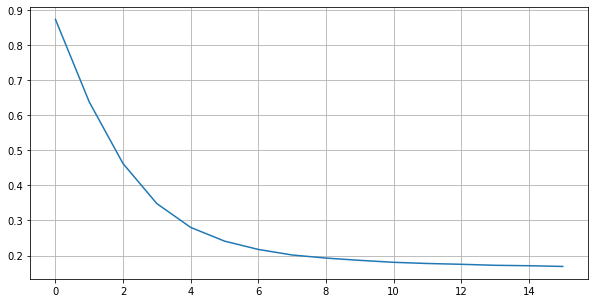

In [20]:
# Fit the pre-trained embeddings
loss = model.initialise_embeddings(
    data=data_unique,
    embeddings=embeddings_pca,
    iterations=16
) 

plt.figure(figsize=(10,5))
plt.plot(loss)
plt.grid()
plt.show()

## Training

Model-training is done on the labeled (supervised) data and tries to reshape the embedding-space in a meaningful way. This *reshaping* happens via a *push-pull technique*:
 - **push** This training step pushes away the samples that do not belong in the same cluster. Say for example you have the samples `KU Leuven` and `UGent`, these do not belong in the same cluster, and thus should have a low cosine-similarity.
 - **pull** This training step pulls all the samples that belong in the same cluster together. Say for example you have the samples `KU Leuven` and `KUL`, these two samples belong to the same cluster, and thus should be close to each other.
 
Every `iteration`, one push and one pull are performed (in that order). Every `epoch`, there is the option to check new samples for which the model is uncertain about. This enables you to only annotate the most relevant samples.

In [21]:
tf.get_logger().setLevel('ERROR')
loss, loss_split = model.train(
    data=data_clean,
    epochs=1,
    iterations=32,
    n_replaces=50,
    show_overview=True,
)
tf.get_logger().setLevel('INFO')

Loss ???:   0%|          | 0/32 [00:00<?, ?it/s]

==> Running epoch 1 <==


Loss 0.01573: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]



Training-clustering overview:
 - Unclustered: 66.99% (485/724)
 - Largest cluster: 136
 - Average cluster: 29.875
 - Largest cluster: 9


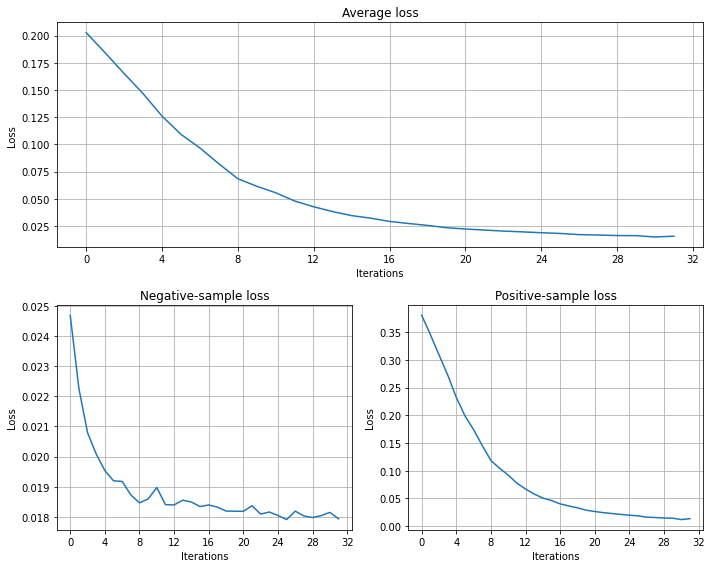

In [22]:
# Plot the loss-graphs
loss_neg, loss_pos = zip(*loss_split)
plt.figure(figsize=(10, 8))
ax = plt.subplot(2, 1, 1)
plt.plot(loss)
plt.title("Average loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax = plt.subplot(2, 2, 3)
plt.plot(loss_neg)
plt.title("Negative-sample loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax = plt.subplot(2, 2, 4)
plt.plot(loss_pos)
plt.title("Positive-sample loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
_ = plt.plot()

In [23]:
# Get overview of all validation predictions
val_result = model.validate(
    print_result=True,
)

print(f"\n\nClustering results:")
for a,b,c in val_result:
    print(f" - Clustering item '{a}'")
    print(f"   -->    Target-class: '{b}'")
    print(f"   --> Predicted-class: '{c}'")


Validation result:
 - Accuracy: 79.17% (19/24)
 - None-cluster: 41.67% (10/24)
 - Not-None cluster: 58.33% (14/24)
 - Correct cluster (not-None): 73.68% (14/19)
 - Wrong cluster (not-None): 0.0% (0/19)


Clustering results:
 - Clustering item 'hogent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'hogere zeevaartschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho sint lieven gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'karel de grote hogeschool katholieke hogeschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'groep t leuven'
   -->    Target-class: 'Catholic University of Leuven'
   --> Predicted-class: 'Catholic University of Leuven'
 - Clustering item 'k u leuven'
   -->    Target-class: 'Catholic University of Leu

In [24]:
# Get ratio of data clustered
pred = model(data_unique)
pred_count = Counter(pred)
print(f"Prediction cluster-distribution:")
print(f" - Average of {round(100*len([p for p in pred if p])/len(pred), 2)}% clustered")
print(f" - Maximum cluster-size (not-None): {max(v for k,v in pred_count.items() if k)} samples")
print(f" - Average cluster-size (not-None): {round(sum(v for k,v in pred_count.items() if k)/(len(pred_count)-1))} samples")
print(f" - Minimum cluster-size (not-None): {min(v for k,v in pred_count.items() if k)} samples")
print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")

Prediction cluster-distribution:
 - Average of 31.87% clustered
 - Maximum cluster-size (not-None): 133 samples
 - Average cluster-size (not-None): 32 samples
 - Minimum cluster-size (not-None): 8 samples
 - Cluster by count:
   - None (481)
   - Catholic University of Leuven (133)
   - Free University of Brussels (31)
   - University of Ghent (22)
   - Vlerick Business School (12)
   - University of Antwerp (11)
   - Solvay Business School (8)
   - University of Hasselt (8)


In [25]:
# Get ratio of data clustered
pred = model(data)
pred_count = Counter(pred)
print(f"Prediction cluster-distribution, absolute figures:")
print(f" - Average of {round(100*len([p for p in pred if p])/len(pred), 2)}% clustered")
print(f" - Maximum cluster-size (not-None): {max(v for k,v in pred_count.items() if k)} samples")
print(f" - Average cluster-size (not-None): {round(sum(v for k,v in pred_count.items() if k)/(len(pred_count)-1))} samples")
print(f" - Minimum cluster-size (not-None): {min(v for k,v in pred_count.items() if k)} samples")
print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")

Prediction cluster-distribution, absolute figures:
 - Average of 62.68% clustered
 - Maximum cluster-size (not-None): 1620 samples
 - Average cluster-size (not-None): 420 samples
 - Minimum cluster-size (not-None): 71 samples
 - Cluster by count:
   - None (1750)
   - Catholic University of Leuven (1620)
   - University of Ghent (540)
   - Free University of Brussels (285)
   - Vlerick Business School (179)
   - University of Antwerp (149)
   - Solvay Business School (95)
   - University of Hasselt (71)


## Visualise result

Visualise the embedding-space and (predicted) clusters using TensorBoard's Projector.

In [26]:
model.visualise_tensorboard(
    data=data_unique,
    path_projector=Path.cwd() / 'demos/projector'
)

Run tensorboard in terminal:
tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_emb_init

Or run tensorboard in notebook:
%load_ext tensorboard
%tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_emb_init
